<a href="https://colab.research.google.com/github/Abhi-kumar-21/3D-NUS-NMR-Reconstruction/blob/main/real_3D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
from time import time
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import keras
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn import preprocessing
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv3D, MaxPooling3D
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

#Parallelization library
from multiprocessing import Pool, Manager, Process
import threading

from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/My Drive/Scheduler.xlsx')

arr = df.to_numpy().astype('int')

mul_arr = np.zeros((128,32),'float')
for d in arr:
  mul_arr[d[0],d[1]] = 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mul_arr

array([[1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def make_fid(freqs, freqs1, freqs2, r2s, ints, noise=False):
    
  retval=np.zeros( (NP, NP1, NP2) , dtype=np.complex)
  
  # Time samples
  samp_time = np.linspace(0.,(NP-1.)/SW,NP)
  samp_time1 = np.linspace(0.,(NP1-1.)/SW1,NP1)
  samp_time2 = np.linspace(0.,(NP2-1.)/SW2,NP2)
  
  K = np.max([len(freqs), len(freqs2), len(freqs2), len(r2s), len(ints)])
  for n in range(NP):
    for n1 in range(NP1):
      for n2 in range(NP2):
        val = 0.
        for s in range(K):
          val+= (np.exp((1j*2*np.pi*freqs[s] - r2s[s])*samp_time[n])*
                  np.exp((1j*2*np.pi*freqs1[s] - r2s[s])*samp_time1[n1])*
                  np.exp((1j*2*np.pi*freqs2[s] - r2s[s])*samp_time2[n2])*
                  ints[s])
        retval[n,n1,n2]=val

  return retval


def make_sine_combinations():

  # Number of Signals
  nSignals = random.randint(50,NSignals+1)  
  # print(nSignals)

  # Frequencies
  freqs = np.random.random(nSignals)*SW
  freqs1 = np.random.random(nSignals)*SW1
  freqs2 = np.random.random(nSignals)*SW2

  # Transverse relaxation rate
  r2s = np.random.random(nSignals)*(5) + (1/100)

  #Intensity = amplitude
  ints = np.random.random(nSignals)*5 + 1

  # FID creation
  ff = make_fid(freqs,freqs1,freqs2,r2s,ints,NoiseLevel)

  temp_realPart = np.real(ff)
  temp = np.abs(temp_realPart[0,0,0])
  ff = ff/temp

  return ff


def make_2d_mat(b_size):
    
  # Training matrix
  target = np.zeros([b_size*NP, NP1*NP2], dtype=np.float)       # For Target
  train = np.zeros([b_size*NP, NP1, NP2], dtype=np.float)      # For CNN
  train1 = np.zeros([b_size*NP, NP1, NP2], dtype=np.float)     # For test_fft
  train_1 = np.zeros([b_size*NP, NP1*NP2], dtype=np.float)      # For DNN

  # Matix concatenation (training)
  for i in range(b_size):
    ff = make_sine_combinations()
    train_ff = ff

    ff = np.fft.fft(ff,axis=0)
    ff = np.fft.fft(ff,axis=1)
    ff = np.fft.fft(ff,axis=2)

    ff = ff/np.max(np.abs(ff))

    train1[i*NP:(i+1)*NP,:,:] = np.real(ff)

    for j in range(NP):
      train_ff[j,:,:] = np.multiply(train_ff[j,:,:],mul_arr)
      index = (i*NP)+j
      target[index,:] = np.real(ff[j]).reshape(NP1*NP2)
    
    train_ff = np.fft.fft(train_ff,axis=0)
    train_ff = np.fft.fft(train_ff,axis=1)
    train_ff = np.fft.fft(train_ff,axis=2)

    train_ff = train_ff/np.max(np.abs(train_ff))

    train[i*NP:(i+1)*NP,:,:] = np.real(train_ff)
    
    for j in range(NP):
      index = (i*NP)+j
      train_1[index,:] = np.real(train_ff[j]).reshape(NP1*NP2)

  return train, train1, target

N = 5000
NP = 2        # Direct dimension
NP1 = 128     # Indirect Dimension 1
NP2 = 64      # Indirect Dimension 1
SW = 1000
SW1 = 10000
SW2 = 4000
NoiseLevel = 0
NSignals = 25
dataIn = []
dataOut = []
epochs = 12
batch_size = 32
val_split = 0.05


In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU 

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np


In [ ]:
#===============================================================================
# Densenet Network Architecture

def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = tf.keras.activations.tanh(x)
    # x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=1, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 3, strides=1, padding='same')(input)
  x = MaxPool2D(3, strides=1, padding='same')(x)
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)

  
  output = Conv2D(1, 1, activation='tanh')(d)
  
  model = Model(input, output)
  return model




input_shape = 128, 64, 1
n_classes = 4096

K.clear_session()
model = densenet(input_shape, n_classes)
model.summary()

# Compile the model
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
lr_metric = get_lr_metric(optimizer)

reduce_lr = ReduceLROnPlateau(monitor="loss",
                              factor=0.8,
                              patience=9,
                              min_lr=0.0001
)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 64, 64)  640         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 64, 64)  0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 64, 64)  256        ['max_pooling2d[0][0]']      

In [ ]:
def dothing(x1_train, fids, fids_flat, i):
    x1, fids_1, fids_2 = make_2d_mat(16)
    print("yolo")
    # print(x1[0,:,:,:], fids_2[0,:])
    # print(x1.shape, fids_1.shape)
    fids.append(fids_1)
    x1_train.append(x1)
    fids_flat.append(fids_2)

In [ ]:
num_threads = 16

for n_datasets in range(100):
    # print(n_datasets)
    with Manager() as manager:
        # L = manager.list()  # <-- can be shared between processes.
        x1_train = manager.list()
        fids = manager.list()
        fids_flat = manager.list()
        processes = []
        for i in range(num_threads):
            # p = Process(target=dothing, args=(x1_train, fids, fids_flat, i))  # Passing the list
            p = threading.Thread(target=dothing, args=(x1_train, fids, fids_flat, i))
            # print(p)
            # processes.append(p)
            p.start()
            processes.append(p)
        for p in processes:
            p.join()
        x1_train = np.vstack(x1_train)
        fids = np.vstack(fids)
        fids_flat = np.vstack(fids_flat)
      
    print(f"This is the iteration number{n_datasets}")
    print(x1_train.shape, fids.shape)
    print(x1_train[0,:,:], fids[0,:,:])


    X_train, X_test, y_train, y_test = train_test_split(x1_train, fids, test_size=0.2)

    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=10)

    loss = np.log10(history.history["loss"])
    val_loss = np.log10(history.history['val_loss'])
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(loss)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    del x1_train, fids, fids_flat

Exception in thread Thread-28:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-9-32df37c93b60>", line 2, in dothing
    x1, fids_1, fids_2 = make_2d_mat(16)
  File "<ipython-input-6-aa03a4e7a277>", line 62, in make_2d_mat
    ff = make_sine_combinations()
  File "<ipython-input-6-aa03a4e7a277>", line 28, in make_sine_combinations
    nSignals = random.randint(50,NSignals+1)
  File "/usr/lib/python3.7/random.py", line 222, in randint
    return self.randrange(a, b+1)
  File "/usr/lib/python3.7/random.py", line 200, in randrange
    raise ValueError("empty range for randrange() (%d,%d, %d)" % (istart, istop, width))
ValueError: empty range for randrange() (50,27, -23)

Exception in thread Thread-29:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _

ValueError: ignored

In [ ]:
ls

drive/  sample_data/


In [ ]:
import os

from google.colab import drive

drive.mount('/content/drive')

os.getcwd()

os.chdir('drive')

os.chdir('MyDrive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls

'120100094 - 1.pdf'
 3Dexpts/
'Aadhar and Gas Connection Bill.pdf'
 Abhishek_Kumar_02.pdf
 Abhishek_Kumar_Blank_Template-18.pdf
'Abhishek_Kumar_CDS (1).pdf'
'Abhishek_Kumar_CDS (2).pdf'
 Abhishek_Kumar_CDS.pdf
'Abhishek_Kumar_Resume (1).pdf'
 Abhishek_Kumar_resume.pdf
 Abhishek_Kumar_Resume.pdf
'abhishek one page 1.pdf'
'BPCL Resume_Part A_Engineers.DOCX'
'BPCL Resume_Part A_Engineers.DOCX.gdoc'
'Colab Notebooks'/
'Copy of hnco_3d'@
 DAV/
 EDHRN_3D.h5
 Event.gsite
'Forms for use.GT(M)'/
'Forms for use.GT(M).rar'
 hncacb_3d/
 hncaco_3d/
 hnco_3d@
 hnco_3d_1/
 hnco_3d_h/
 hncocacb_3d/
'IISc_Abhishek_Kumar_CDS (1).pdf'
'IISc_Abhishek_Kumar_CDS (2).pdf'
'IISc_Abhishek_Kumar_CDS (3).pdf'
'IISc_Abhishek_Kumar_CDS (4).pdf'
 IISc_Abhishek_Kumar_CDS.pdf
 IISC_ID.pdf
 Introduction_to_RBMs.pdf
 lec1-handout.pdf
 lec25-handout.pdf
"Master's_Project_Abstarct.docx"
 model_plot.png
'New Doc 5_5.pdf'
'Night drive'/
'pawna lake camping'/
 Portfolio.gsite
'proposal(17830_&_18208).pdf'
 proposal.pdf
 rec

In [ ]:
def bce_dice_loss(y_true, y_pred):
    return NMSE(y_true, y_pred)

def NMSE(y_true, y_pred):
    a = K.sqrt(K.sum(K.square(y_true - y_pred)))
    b = K.sqrt(K.sum(K.square(y_true)))
    return a / b
model = tf.keras.models.load_model(os.path.join( "EDHRN_3D.h5"), custom_objects={'bce_dice_loss':bce_dice_loss, 'NMSE':NMSE})

In [ ]:
new_model = tf.keras.models.load_model('saved_model_1/my_model_1')

OSError: ignored

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 128, 32, 64)  1664        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 32, 64)  0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 32, 64)  256        ['max_pooling2d[0][0]']      

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 120, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 120, 120, 48  105        ['main_input[0][0]']             
 onv2D)                         )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 120, 120, 48  192        ['separable_conv2d_1[0][0]']     
 rmalization)                   )                                                           

In [ ]:
def make_fid(freqs, freqs1, freqs2, r2s, ints, noise=False):
    
  retval=np.zeros( (NP, NP1, NP2) , dtype=np.complex)
  
  # Time samples
  samp_time = np.linspace(0.,(NP-1.)/SW,NP)
  samp_time1 = np.linspace(0.,(NP1-1.)/SW1,NP1)
  samp_time2 = np.linspace(0.,(NP2-1.)/SW2,NP2)
  
  K = np.max([len(freqs), len(freqs2), len(freqs2), len(r2s), len(ints)])
  for n in range(NP):
    for n1 in range(NP1):
      for n2 in range(NP2):
        val = 0.
        for s in range(K):
          val+= (np.exp((1j*2*np.pi*freqs[s] - r2s[s])*samp_time[n])*
                  np.exp((1j*2*np.pi*freqs1[s] - r2s[s])*samp_time1[n1])*
                  np.exp((1j*2*np.pi*freqs2[s] - r2s[s])*samp_time2[n2])*
                  ints[s])
        retval[n,n1,n2]=val

  return retval


def make_sine_combinations():

  # Number of Signals
  nSignals = 80 #random.randint(200,NSignals+1)  
  # print(nSignals)

  # Frequencies
  freqs = np.random.random(nSignals)*SW
  freqs1 = np.random.random(nSignals)*SW1
  freqs2 = np.random.random(nSignals)*SW2

  # Transverse relaxation rate
  r2s = np.random.random(nSignals)*(5) + (1/100)

  #Intensity = amplitude
  ints = np.random.random(nSignals)*600000 + 100000

  # FID creation
  ff = make_fid(freqs,freqs1,freqs2,r2s,ints,NoiseLevel)

  temp_realPart = np.real(ff)
  temp = np.abs(temp_realPart[0,0,0])
  ff = ff/temp

  return ff, nSignals


def make_2d_mat(b_size):
    
  # Training matrix
  target = np.zeros([b_size*NP, NP1*NP2], dtype=np.float)       # For Target
  train = np.zeros([b_size*NP, NP1, NP2], dtype=np.float)      # For CNN
  train1 = np.zeros([b_size*NP, NP1, NP2], dtype=np.float)     # For test_fft
  train_1 = np.zeros([b_size*NP, NP1*NP2], dtype=np.float)      # For DNN

  # Matix concatenation (training)
  for i in range(b_size):
    ff, nSignals = make_sine_combinations()
    train_ff = ff

    ff = np.fft.fft(ff,axis=0)
    ff = np.fft.fft(ff,axis=1)
    ff = np.fft.fft(ff,axis=2)

    ff = ff/np.max(np.abs(ff))

    train1[i*NP:(i+1)*NP,:,:] = np.real(ff)
    # train1[i*NP:(i+1)*NP,1,:,:] = np.imag(ff)

    for j in range(NP):
      train_ff[j,:,:] = np.multiply(train_ff[j,:,:],mul_arr)
      # index = (i*(j+1))+j
      index = (i*NP)+j
      # till_index = NP1*NP2
      target[index,:] = np.real(ff[j]).reshape(NP1*NP2)
      # target[index,till_index:2*till_index] = np.imag(ff[j]).reshape(NP1*NP2)
    
    train_ff = np.fft.fft(train_ff,axis=0)
    train_ff = np.fft.fft(train_ff,axis=1)
    train_ff = np.fft.fft(train_ff,axis=2)

    train_ff = train_ff/np.max(np.abs(train_ff))

    train[i*NP:(i+1)*NP,:,:] = np.real(train_ff)
    # train[i*NP:(i+1)*NP,1,:,:] = np.imag(train_ff)
    
    for j in range(NP):
      index = (i*NP)+j
      # till_index = NP1*NP2
      train_1[index,:] = np.real(train_ff[j]).reshape(NP1*NP2)
      # train_1[index,till_index:2*till_index] = np.imag(train_ff[j]).reshape(NP1*NP2)

  return train, train1, target, nSignals

N = 5000
NP = 2        # Direct dimension
NP1 = 120     # Indirect Dimension 1
NP2 = 32      # Indirect Dimension 1
SW = 1000
SW1 = 10000
SW2 = 4000
NoiseLevel = 0
NSignals = 250
dataIn = []
dataOut = []
epochs = 12
batch_size = 32
val_split = 0.05


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import os
import keras
from keras import backend as K
print("Keras = {}".format(keras.__version__))
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import numpy as np
import pylab
import sys
import math
from tensorflow.python.keras.backend import set_session 
# import keras.backend.tensorflow_backend as KTF
from keras.models import load_model
from sklearn import metrics
#from model_logic2 import *
#from generator2 import *
import scipy.io as sio
# from keras.utils import plot_model
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
#config.gpu_options.allow_growth = True
# session = tf.Session(config = config)
# KTF.set_session(session)

# sys.setrecursionlimit(2000)


Keras = 2.8.0


In [ ]:
train, target, target_1d, nSignals = make_2d_mat(1)

In [ ]:
train_ip = np.zeros([80,128,120])
target_2d = np.zeros([80,128,120])

In [ ]:
# train_ip[:,:120,:32] = train
# target_2d[:,:120,:32] = target
train_ip[:,:120,:32] = tar_2
target_2d[:,:120,:32] = fid_2

In [ ]:
loss, acc = model.evaluate(train_ip[:,:120,:], target_2d[:,:120,:])
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


output = model.predict(train_ip[:,:120,:])

3/3 [==============================] - 0s 132ms/step - loss: 0.8599 - NMSE: 0.9044
Restored model, accuracy: 90.44%


In [ ]:
loss, acc = new_model.evaluate(train_ip[:,:,:32], target_2d[:,:,:32])
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


output1 = new_model.predict(train_ip[:,:,:32])

3/3 [==============================] - 3s 369ms/step - loss: 2.0562e-05 - accuracy: 0.0625
Restored model, accuracy:  6.25%


In [ ]:
train_ip.shape

(80, 128, 120)

In [ ]:
output.shape

(80, 120, 120, 1)

In [ ]:
target_2d.shape

(80, 128, 120)

In [ ]:
# z1 = azur[:,:,:,0]
# z = luo[:,:,:,0]
z = np.real(train_ip[:, :, :])

In [ ]:
# X = np.arange(128,dtype=int)
# Y = np.arange(32,dtype=int)
X = np.arange(120,dtype=int)
Y = np.arange(120,dtype=int)
X,Y = np.meshgrid(X,Y)
print(X)
print(Y)

[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [117 117 117 ... 117 117 117]
 [118 118 118 ... 118 118 118]
 [119 119 119 ... 119 119 119]]


In [ ]:
import plotly.graph_objects as go

# fig = go.Figure(figsize=(24,12))

fig = go.Figure(data=[go.Surface(z=z[38,:,:])])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="lightyellow", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

In [ ]:
z_op = np.real(output[:, :, :, 0])

In [ ]:
z_op.shape

In [ ]:
import plotly.graph_objects as go

# fig = go.Figure(figsize=(24,12))

fig = go.Figure(data=[go.Surface(z=z_op[20,:,:])])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

In [ ]:
z_op1 = np.real(output1[:, :, :, 0])

In [ ]:
z_op2 = np.zeros([80,128,120])
z_op2[:,:,:32] = z_op1[:,:,:]
z_op2.shape

In [ ]:
import plotly.graph_objects as go

# fig = go.Figure(figsize=(24,12))

fig = go.Figure(data=[go.Surface(z=z_op2[20,:,:])])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

In [ ]:
z_act = np.real(target_2d[:, :, :])

In [ ]:
z_act.shape

(80, 128, 120)

In [ ]:
import plotly.graph_objects as go

# fig = go.Figure(figsize=(24,12))

fig = go.Figure(data=[go.Surface(z=z_act[0,:,:])])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90)
)

fig.show()

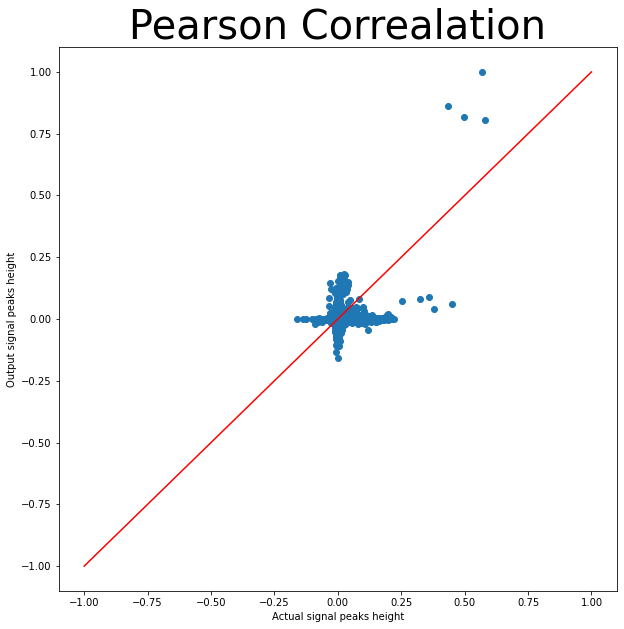

In [ ]:
x = np.linspace(-1,1,100)
y=x
plt.scatter(z_op2, z_act[:,:128,:])
plt.plot(x, y, '-r', label='y=x')
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('Actual signal peaks height')
plt.ylabel('Output signal peaks height')
plt.title(label='Pearson Correalation',
          fontweight=40,
          fontsize = 40)

plt.show()


In [ ]:
nSignals

NameError: ignored

In [ ]:
points = []
temp_2d = np.zeros([130,122], dtype=np.float)
for i in range(2):
  temp_2d[1:129, 1:121] = z_act[i,:,:]
  for j in range(1,129):
    for k in range(1,33):
      if (temp_2d[j,k]>temp_2d[j-1,k-1]) and (temp_2d[j,k]>temp_2d[j-1,k])and (temp_2d[j,k]>temp_2d[j-1,k+1]) and (temp_2d[j,k]>temp_2d[j,k-1]) and (temp_2d[j,k]>temp_2d[j,k+1]) and (temp_2d[j,k]>temp_2d[j+1,k-1]) and (temp_2d[j,k]>temp_2d[j+1,k]) and (temp_2d[j,k]>temp_2d[j+1,k+1]):
        points.append([i,j-1,k-1])


In [ ]:
temp_2d

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02809409, 0.01565592, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00844708, 0.00207817, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
len(points)

723

In [ ]:
z_op_1 = z_op2
z_act_1 = z_act 

origin = [0,0,0]

xyz = []
xyz.append(origin)
print(len(points))



for xy in points:
  flag = 0
  for i in range(len(xyz)):
    # print('hi')
    if (z_act[xy[0],xy[1],xy[2]] > z_act[xyz[i][0],xyz[i][1],xyz[i][2]]) or (z_act[xy[0],xy[1],xy[2]] == z_act[xyz[i][0],xyz[i][1],xyz[i][2]]):
      xyz.insert(i,xy)
      flag = 1
      break
  if flag==0:
    xyz.append(xy)

723


In [ ]:
len(xyz)

724

In [ ]:
# xyz

In [ ]:
print(z_act[1, 92, 11], z_act[0, 10, 23])

-0.0011311587309334715 -0.0006560437855005061


In [ ]:
for i in range(80):
  for j in range(128):
    for k in range(32):
      # if (z_act[i,j,k]<0.1):
      if [i,j,k] not in xyz:
        z_op2[i,j,k] = 0
        z_act[i,j,k] = 0
# for i in range(79):
#   for j in range(128):
#     for k in range(32):
#       if z_act[i,j,k] < 0:
#         z_act[i,j,k] = 0


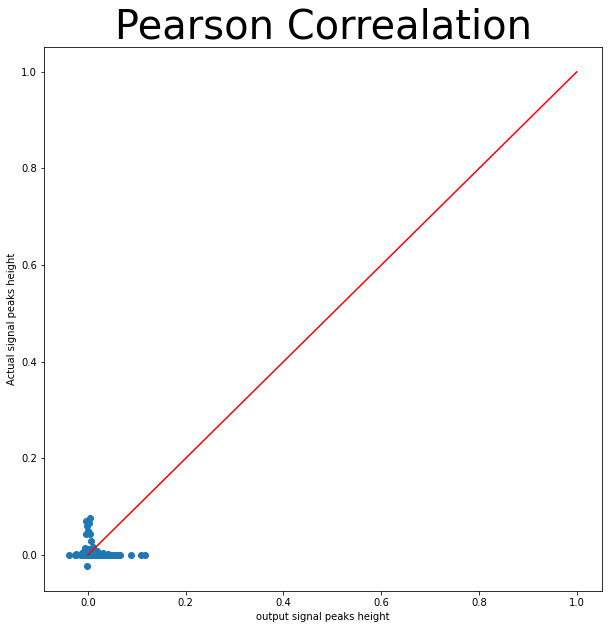

In [ ]:
x = np.linspace(0,1,100)
y=x
plt.scatter(z_op2, z_act[:,:128:,:])
plt.plot(x, y, '-r', label='y=x')
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('output signal peaks height')
plt.ylabel('Actual signal peaks height')
plt.title(label='Pearson Correalation',
          fontweight=40,
          fontsize = 40)

plt.show()

In [ ]:
from scipy.stats import pearsonr

from sklearn.metrics import r2_score 
# a =[1, 2, 3, 4, 5] 
# b =[1, 2.5, 3, 4.9, 5.1] 
R_square = r2_score(list(z_act.reshape(8192,)),list(z_op.reshape(8192,))) 
print('Coefficient of Determination', R_square) 

corr, _ = pearsonr(list(z_act.reshape(8192,)),list(z_op.reshape(8192,)))
print('Pearsons correlation: %.3f' % corr)

Coefficient of Determination 0.8889300965569372
Pearsons correlation: 0.945


In [ ]:
# stat = []
# r_sq = []
# for k in range(100):
#   train_ip, target_2d, target_1d, nSignals = make_2d_mat(1)
#   loss, acc = new_model.evaluate(train_ip, target_2d)
#   # print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

#   output = new_model.predict(train_ip)
#   z_op = np.real(output[:, :, :, 0])
#   z_act = np.real(target_2d[:, :, :])
#   points = []
#   temp_2d = np.zeros([130,34], dtype=np.float)
#   for i in range(2):
#     temp_2d[1:129, 1:33] = z_act[i,:,:]
#     for j in range(1,129):
#       for k in range(1,33):
#         if (temp_2d[j,k]>temp_2d[j-1,k-1]) and (temp_2d[j,k]>temp_2d[j-1,k])and (temp_2d[j,k]>temp_2d[j-1,k+1]) and (temp_2d[j,k]>temp_2d[j,k-1]) and (temp_2d[j,k]>temp_2d[j,k+1]) and (temp_2d[j,k]>temp_2d[j+1,k-1]) and (temp_2d[j,k]>temp_2d[j+1,k]) and (temp_2d[j,k]>temp_2d[j+1,k+1]):
#           points.append([i,j-1,k-1])

#   origin = [0,0,0]

#   xyz = []
#   xyz.append(origin)
#   print(len(points))



#   for xy in points:
#     flag = 0
#     for i in range(len(xyz)):
#       # print('hi')
#       if (z_act[xy[0],xy[1],xy[2]] > z_act[xyz[i][0],xyz[i][1],xyz[i][2]]) or (z_act[xy[0],xy[1],xy[2]] == z_act[xyz[i][0],xyz[i][1],xyz[i][2]]):
#         xyz.insert(i,xy)
#         flag = 1
#         break
#     if flag==0:
#       xyz.append(xy)

#   for i in range(2):
#     for j in range(128):
#       for k in range(32):
#         # if (z_act[i,j,k]<0.1):
#         if [i,j,k] not in xyz[:nSignals]:
#           z_op[i,j,k] = 0
#           z_act[i,j,k] = 0

#   R_square = r2_score(list(z_act.reshape(8192,)),list(z_op.reshape(8192,))) 
#   # print('Coefficient of Determination', R_square) 
#   corr, _ = pearsonr(list(z_act.reshape(8192,)),list(z_op.reshape(8192,)))
#   stat.append(corr)
#   r_sq.append(R_square)

# print(np.mean(stat))
# print(np.mean(r_sq))


In [ ]:
ls

drive/  sample_data/


In [ ]:
import os

from google.colab import drive

drive.mount('/content/drive')

os.getcwd()

os.chdir('drive')

os.chdir('MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls

'120100094 - 1.pdf'
 3Dexpts/
'Aadhar and Gas Connection Bill.pdf'
 Abhishek_Kumar_02.pdf
 Abhishek_Kumar_Blank_Template-18.pdf
'Abhishek_Kumar_CDS (1).pdf'
'Abhishek_Kumar_CDS (2).pdf'
 Abhishek_Kumar_CDS.pdf
'Abhishek_Kumar_Resume (1).pdf'
 Abhishek_Kumar_resume.pdf
 Abhishek_Kumar_Resume.pdf
'abhishek one page 1.pdf'
'BPCL Resume_Part A_Engineers.DOCX'
'BPCL Resume_Part A_Engineers.DOCX.gdoc'
'Colab Notebooks'/
'Copy of hnco_3d'@
 DAV/
 EDHRN_3D.h5
 Event.gsite
'Forms for use.GT(M)'/
'Forms for use.GT(M).rar'
 hncacb_3d/
 hncaco_3d/
 hnco_3d@
 hnco_3d_1/
 hnco_3d_h/
 hncocacb_3d/
'IISc_Abhishek_Kumar_CDS (1).pdf'
'IISc_Abhishek_Kumar_CDS (2).pdf'
'IISc_Abhishek_Kumar_CDS (3).pdf'
'IISc_Abhishek_Kumar_CDS (4).pdf'
 IISc_Abhishek_Kumar_CDS.pdf
 IISC_ID.pdf
 Introduction_to_RBMs.pdf
 lec1-handout.pdf
 lec25-handout.pdf
"Master's_Project_Abstarct.docx"
 model_plot.png
'New Doc 5_5.pdf'
'Night drive'/
'pawna lake camping'/
 Portfolio.gsite
'proposal(17830_&_18208).pdf'
 proposal.pdf
 rec

In [ ]:
pip install nmrglue

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 7.8 MB/s 


In [ ]:
import nmrglue as ng

In [ ]:
dic,data = ng.pipe.read('3Dexpts/cbcaconh_3d/data/test001.fid')

In [ ]:
data.shape

(120, 576)

In [ ]:
data

array([[-352.1494   +2.93676758e+02j, -321.8401   +2.69882324e+02j,
        -361.55737  +2.69970215e+02j, ...,   24.491806 +3.43650513e+01j,
          44.360947 +2.71956787e+01j,   30.524933 +2.62573242e-01j],
       [ -27.890625 -3.14898438e+02j, -228.29663  -1.62468262e+02j,
        -170.99658  -1.88528809e+02j, ...,  -16.298843 +2.43219910e+01j,
         -15.602783 +3.24124146e+01j,   -8.102188 +1.58103485e+01j],
       [ 462.0913   +8.71982422e+01j,  464.3086   +7.57875977e+01j,
         417.05542  +4.30283203e+01j, ...,   26.325378 +3.71196899e+01j,
          45.15703  +4.42872314e+01j,   24.593811 +1.85956650e+01j],
       ...,
       [-231.02454  -5.79165039e+01j,   -1.5752563-1.06997070e+02j,
         -27.947144 -6.37036133e+01j, ...,   -3.7349625-1.02151276e+02j,
          -1.7664738-1.13435165e+02j,   -1.6202431-5.62449570e+01j],
       [ 221.42737  +3.98259277e+02j,  295.26343  +3.99253906e+02j,
         251.67175  +2.74902344e+02j, ...,    4.104141 -6.92031403e+01j,
       

In [ ]:
from pathlib import Path

files = []

entries = Path('3Dexpts/cbcaconh_3d/data/')
for entry in entries.iterdir():
    # print(entry.name)
    files.append(entry.name)

In [ ]:
files.sort()
# files

In [ ]:
files[:]

['test001.fid',
 'test002.fid',
 'test003.fid',
 'test004.fid',
 'test005.fid',
 'test006.fid',
 'test007.fid',
 'test008.fid',
 'test009.fid',
 'test010.fid',
 'test011.fid',
 'test012.fid',
 'test013.fid',
 'test014.fid',
 'test015.fid',
 'test016.fid',
 'test017.fid',
 'test018.fid',
 'test019.fid',
 'test020.fid',
 'test021.fid',
 'test022.fid',
 'test023.fid',
 'test024.fid',
 'test025.fid',
 'test026.fid',
 'test027.fid',
 'test028.fid',
 'test029.fid',
 'test030.fid',
 'test031.fid',
 'test032.fid',
 'test033.fid',
 'test034.fid',
 'test035.fid',
 'test036.fid',
 'test037.fid',
 'test038.fid',
 'test039.fid',
 'test040.fid',
 'test041.fid',
 'test042.fid',
 'test043.fid',
 'test044.fid',
 'test045.fid',
 'test046.fid',
 'test047.fid',
 'test048.fid',
 'test049.fid',
 'test050.fid',
 'test051.fid',
 'test052.fid',
 'test053.fid',
 'test054.fid',
 'test055.fid',
 'test056.fid',
 'test057.fid',
 'test058.fid',
 'test059.fid',
 'test060.fid',
 'test061.fid',
 'test062.fid',
 'test06

In [ ]:
fid_signal = np.zeros([80,576,120], dtype=complex)
i=0
for x in files[:-1]:
  folder = "3Dexpts/cbcaconh_3d/data/"
  x = folder + x
  dic,data = ng.pipe.read(x)
  fid_signal[i,:,:] = data.T
  i=i+1

In [ ]:
fid_signal

array([[[ 5.66016968e+02+1.70914221e+03j,
          3.15825195e+01+8.56325684e+01j,
         -3.68120850e+02+6.64927490e+02j, ...,
         -8.04431152e+01+4.32006226e+01j,
         -1.96698975e+02+6.29370422e+02j,
         -1.38520508e+02-1.22472809e+02j],
        [-9.85215820e+02+1.00564587e+03j,
         -3.66333008e+01-4.72960205e+01j,
         -9.10367554e+02+2.83710205e+02j, ...,
         -9.57595215e+01-1.53866119e+02j,
         -2.92991699e+02+6.28649963e+02j,
         -2.81420898e+00-9.29815979e+01j],
        [-7.84684326e+02-1.03887073e+03j,
         -1.79924316e+01+6.01107178e+01j,
         -8.36996216e+02-1.95852295e+02j, ...,
         -3.82495117e+01-9.38364258e+01j,
         -2.80633057e+02+4.89670563e+02j,
          3.22412109e+01+6.70348511e+01j],
        ...,
        [-2.04473572e+01+2.98270264e+01j,
          3.53002014e+01-2.30703735e+01j,
         -1.45463257e+01+5.96391907e+01j, ...,
          1.26327515e-01-1.06120033e+01j,
          3.47506714e+00-3.45288277e+01j

In [ ]:
fid_signal.shape

(80, 576, 120)

In [ ]:
fid_1 = fid_signal[:,:120,:32]

fid_1 = np.fft.fft(fid_1,axis=0)
fid_1 = np.fft.fft(fid_1,axis=1)
fid_1 = np.fft.fft(fid_1,axis=2)

In [ ]:
fid_2 = np.real(fid_1)
print(fid_2.shape)
fid_2 = fid_2/np.max(np.abs(fid_2))

# train1[i*NP:(i+1)*NP,:,:] = np.real(fid_1)

(80, 120, 32)


In [ ]:
tar_1 = np.multiply(fid_signal[:,:120,:32],mul_arr)
tar_1.shape

(80, 120, 32)

In [ ]:
tar_1 = np.fft.fft(tar_1,axis=0)
tar_1 = np.fft.fft(tar_1,axis=1)
tar_1 = np.fft.fft(tar_1,axis=2)

In [ ]:
tar_2 = np.real(tar_1)
print(tar_2.shape)
tar_2 = tar_2/np.max(np.abs(tar_2))

(80, 120, 32)
